In [1]:
from ase.io import read, write
from ase.visualize import view
from tqdm import tqdm
import nglview as nv
from ase.cell import Cell
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from ase import Atoms
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from ase.data import colors, atomic_numbers
from ase.cell import Cell

In [2]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    magnitude_a = np.linalg.norm(a)
    magnitude_b = np.linalg.norm(b)
    similarity = dot_product / (magnitude_a * magnitude_b)
    return similarity

In [3]:
sizes = ['222']
md_types = ['cluster', 'bulk']

sx_list = []
sy_list = []
for md_type in md_types:
    trajs = read('{}/nvt-pos-1-222.xyz'.format(md_type), index='::1')
    MAPbI3_trajs = []

    indices=[atom.index for atom in trajs[0] if atom.index < 100]
    MAPbI3 = trajs[0][indices]
    vector_a = MAPbI3.positions.flatten()
    sx = []
    sy = []
    for i, atoms in enumerate(tqdm(trajs)):
        MAPbI3 = atoms[indices]
        vector_b = MAPbI3.positions.flatten()
        similarity = cosine_similarity(vector_a, vector_b)
        sx.append(i)
        sy.append(similarity)
        MAPbI3_trajs.append(MAPbI3)
        # view(MAPbI3_trajs, viewer="ngl")
    sx_list.append(sx)
    sy_list.append(sy)

100%|██████████| 8594/8594 [00:00<00:00, 8837.47it/s]


## The similarity

8594


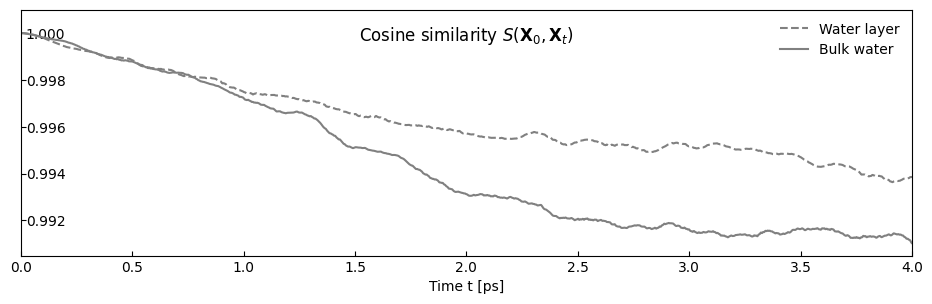

In [4]:
mainColors = {'Pb': '#747b65', 'I':'#6a0045', 'C':'#a7ac9a', 'N':'#2e4ea8', 'O':'#d61f1f', 'DGreen': '#034c3c'}
plt.figure(figsize=(9, 3))
plt.plot(np.array(sx_list[0])/1000, sy_list[0],'--',  label='Water layer', color='grey')
plt.plot(np.array(sx_list[1])/1000, sy_list[1], label='Bulk water',  color='grey')
plt.tick_params(direction='in')
plt.tick_params(axis='y', which='both', right=False, left=True, labelleft=True, pad=-32)
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.01, right=1, bottom=0.17, top=0.99)
# plt.loglog(sx_list[0], sy_list[0], label='Cluster')
# plt.loglog(sx_list[1], sy_list[1], label='Bulk')
print(len(sx_list[1]))
plt.xlim(0, 4)
plt.ylim(0.9905, 1.001)
plt.xlabel('Time t [ps]')
#plt.ylabel('Cosine similarity $S(X_0, X_t)$')

label_text = "Cosine similarity $S(\mathbf{X}_0, \mathbf{X}_t)$"
x_center = np.mean(plt.xlim())
y_top = plt.ylim()[1]
y_offset = 0.15 * (y_top - plt.ylim()[0])
plt.text(x_center, y_top - y_offset, label_text, ha='center', va='bottom', fontsize=12)


plt.legend(frameon=False)
plt.savefig('Similarity.pdf')
plt.savefig('Similarity.png', dpi=300)
plt.show()

In [5]:
def rmsd(a, b):
    """Calculate the root-mean-square deviation (RMSD) between two sets of atoms.

    Parameters:
    a (numpy.ndarray): The positions of the first set of atoms.
    b (numpy.ndarray): The positions of the second set of atoms.

    Returns:
    float: The RMSD between the two sets of atoms.
    """
    assert len(a) == len(b), "Arrays must have the same length."
    n = len(a)
    center_a = np.mean(a, axis=0)
    center_b = np.mean(b, axis=0)
    a_centered = a - center_a
    b_centered = b - center_b
    covariance = np.dot(a_centered.T, b_centered)
    u, s, vt = np.linalg.svd(covariance)
    rotation = np.dot(vt.T, u.T)
    rmsd = np.sqrt((1.0 / n) * np.sum(np.square(np.dot(b_centered, rotation.T) - a_centered)))
    return rmsd

In [6]:
sizes = ['222']
md_types = ['cluster', 'bulk']

dx_list = []
dy_list = []
for md_type in md_types:
    trajs = read('{}/nvt-pos-1-222.xyz'.format(md_type), index='::1')
    MAPbI3_trajs = []

    indices=[atom.index for atom in trajs[0] if atom.index < 100]
    MAPbI3 = trajs[0][indices]
    vector_a = MAPbI3.positions
    dx = []
    dy = []
    for i, atoms in enumerate(tqdm(trajs)):
        MAPbI3 = atoms[indices]
        vector_b = MAPbI3.positions
        similarity = rmsd(vector_a, vector_b)
        dx.append(i)
        dy.append(similarity)
        MAPbI3_trajs.append(MAPbI3)
        # view(MAPbI3_trajs, viewer="ngl")
    dx_list.append(dx)
    dy_list.append(dy)

100%|██████████| 8594/8594 [00:02<00:00, 3333.61it/s]


## The RMSD: root mean square deviation

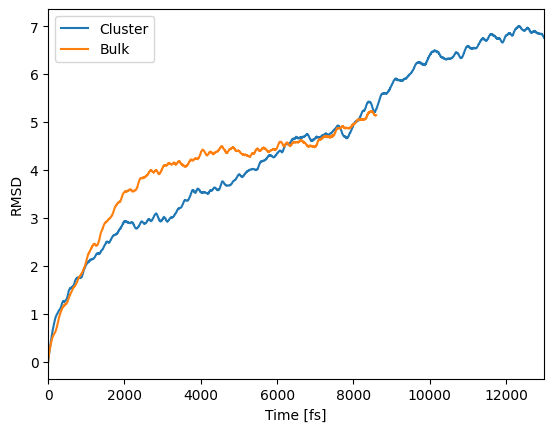

In [7]:
plt.plot(dx_list[0], dy_list[0], label='Cluster')
plt.plot(dx_list[1], dy_list[1], label='Bulk')

# plt.loglog(dx_list[0], dy_list[0], label='Cluster')
# plt.loglog(dx_list[1], dy_list[1], label='Bulk')

plt.xlim(0, len(dx_list[0]))
# plt.ylim(0, 6)
plt.xlabel('Time [fs]')
plt.ylabel('RMSD')
plt.legend()
plt.show()

8594


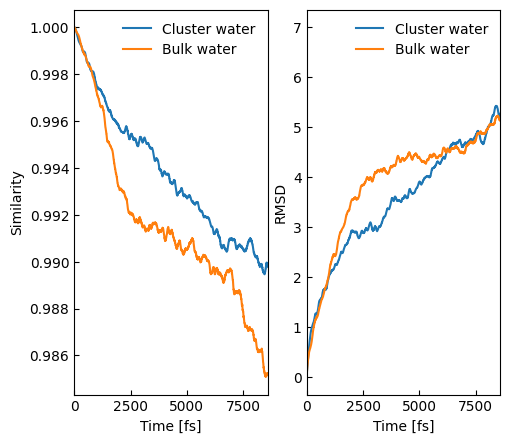

In [8]:
# Combine the two
plt.figure(figsize=(5.5,5))
plt.subplot(1, 2, 1) 
plt.tick_params(direction="in")
plt.plot(sx_list[0], sy_list[0], label='Cluster water')
plt.plot(sx_list[1], sy_list[1], label='Bulk water')
# plt.loglog(sx_list[0], sy_list[0], label='Cluster')
# plt.loglog(sx_list[1], sy_list[1], label='Bulk')
print(len(sx_list[1]))
plt.xlim(0, 8594)
# plt.ylim(0.985, 1.001)
plt.xlabel('Time [fs]')
plt.ylabel('Similarity')
plt.legend(frameon=False)

plt.subplot(1, 2, 2) 
plt.tick_params(direction="in")
plt.plot(dx_list[0], dy_list[0], label='Cluster water')
plt.plot(dx_list[1], dy_list[1], label='Bulk water')

# plt.loglog(dx_list[0], dy_list[0], label='Cluster')
# plt.loglog(dx_list[1], dy_list[1], label='Bulk')

# plt.xlim(0, len(dx_list[0]))
plt.xlim(0, 8594)
# plt.ylim(0, 6)
plt.xlabel('Time [fs]')
plt.ylabel('RMSD')
plt.legend(frameon=False)
plt.savefig('Simi-RMSD.pdf')
plt.show()

## Graph representation of bond connections

In [9]:
# Load the start structure
#!rsync -Pr jiehuang@10.4.1.115:/data/home/jiehuang/Github/MAPbI3_Water/5_water/03_water_opt/cluster_222_water_big_box_nofix_mpi_n/Water_cluster222.xyz .

In [10]:
start_structure = read('Water_cluster222.xyz')
indices = [i for i in range(100)]
view(start_structure[indices])

<Popen: returncode: None args: ['/Users/mac/.jackprogram/anaconda3/bin/pytho...>

In [11]:
# Get the indices of all Pb, I atoms
Pb_indices = np.where([element == 'Pb' for element in start_structure.get_chemical_symbols()])[0]
I_indices = np.where([element == 'I' for element in start_structure.get_chemical_symbols()])[0]

In [12]:
Pb_indices

array([36, 37, 38, 39, 40, 41, 42, 43])

In [13]:
Pb_indices

array([36, 37, 38, 39, 40, 41, 42, 43])

In [14]:
I_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [15]:
# U, D, L, R, F, B
# 0, 1, 2, 3, 4, 5
Pb_connections = np.array([[7,  0,  4,  8,  6,  9], [10, 1,  5, 11, 9, 12],
                                                  [14, 2, 8, 15, 13, 16], [17, 3, 11, 18, 16, 19],
                                                  [23, 7, 20, 24, 22, 25], [26, 10, 21, 27, 25, 28], 
                                                  [30, 14, 24, 31, 29, 32], [33, 17, 27, 34, 32, 35]])

In [16]:
Pb_connections

array([[ 7,  0,  4,  8,  6,  9],
       [10,  1,  5, 11,  9, 12],
       [14,  2,  8, 15, 13, 16],
       [17,  3, 11, 18, 16, 19],
       [23,  7, 20, 24, 22, 25],
       [26, 10, 21, 27, 25, 28],
       [30, 14, 24, 31, 29, 32],
       [33, 17, 27, 34, 32, 35]])

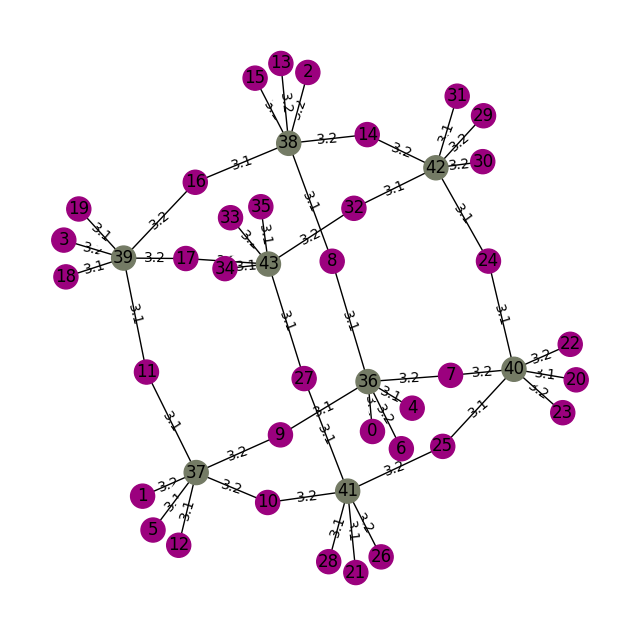

In [17]:
# Create an empty graph object
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(Pb_indices)
G.add_nodes_from(I_indices)

color_map = {i: mainColors['Pb'] for i in Pb_indices}
color_map.update({i: '#9B017E' for i in I_indices})



nx.set_node_attributes(G, color_map, 'color')

# G.add_edge(36, 1)
angles = []
distances = []
PbI_len =  3.4
for i, Pb_index in enumerate(Pb_indices):
    for c in Pb_connections[i]:
        dist = start_structure.get_distance(Pb_index, c)
        # if dist < PbI_len:
            # Add edges to the graph
        G.add_edge(Pb_index, c, distance='{:.1f}'.format(dist))
        distances.append(dist)
#     print(Pb_connections[i][1], Pb_index, Pb_connections[i][2])
    # U, D, L, R, F, B
    # 0, 1, 2, 3, 4, 5
    directions = {direction: index for direction, index in zip(['U', 'D', 'L', 'R', 'F', 'B'], [0, 1, 2, 3, 4, 5])}
    # print(directions)
    # (D, c, L), (D, c, R),  (D, c, F), (D, c, B) 
    # (U, c, L), (U, c, R),  (R, c, F), (R, c, B) 
    # (L, c, B), (B, c, R), (R, c, F), (F, c, L)
    ACBs = [(Pb_connections[i][directions[a]], Pb_index, Pb_connections[i][directions[b]]) for (a, b) in [('D', 'L'), ('D', 'R'), ('D', 'F'), ('D', 'B'),\
                                                                                                       ('U', 'L'), ('U', 'R'), ('R', 'F'), ('R', 'B'), \
                                                                                                       ('L', 'B'), ('B', 'R'), ('R', 'F'), ('F', 'L')]]
    #print(ACBs)
    for acb in ACBs:
        angle = start_structure.get_angle(acb[0], acb[1], acb[2])
        angles.append(angle)
        #print(angle)

angles = np.array(angles)
distances = np.array(distances)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
elabels = nx.get_edge_attributes(G,'distance')
nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels)
nx.draw(G,  pos=pos, with_labels = True, node_color=color_map.values())

plt.show()

## Degree distribution

[0, 24, 12, 0, 0, 0, 8]


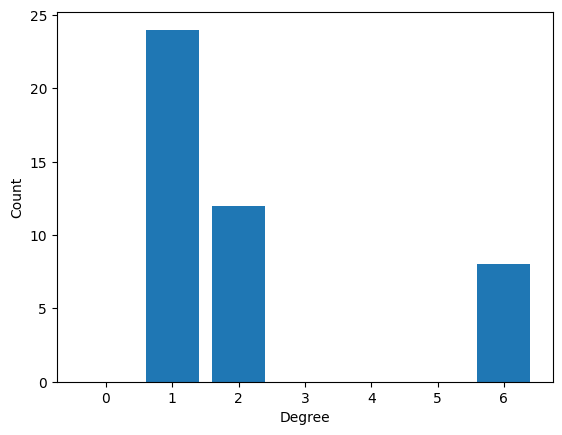

In [18]:
# 计算度分布
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = dict(zip(*np.unique(degree_sequence, return_counts=True)))
degree_hist = [degree_count.get(degree, 0) for degree in range(max(degree_count.keys()) + 1)]
print(degree_hist)
# 可视化度分布
# plt.grid(linewidth=1, which ='both')
plt.bar(range(len(degree_hist)), degree_hist)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

## Angle distrubutions

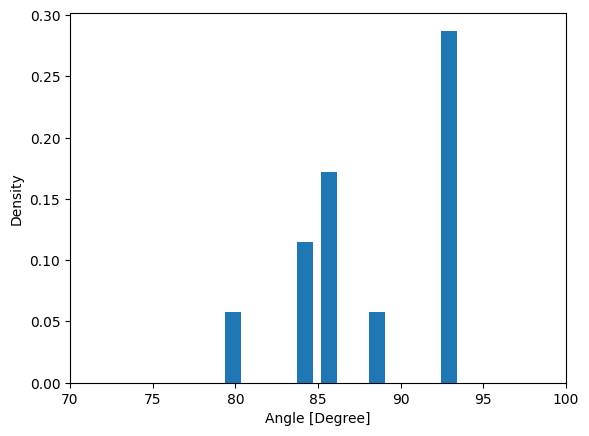

In [19]:
hist, bin_edges = np.histogram(angles, density=True)
plt.bar(bin_edges[:-1], hist, width=1)
plt.xlim(70, 100)
plt.xlabel('Angle [Degree]')
plt.ylabel('Density')
plt.show()

## Bond length distribution

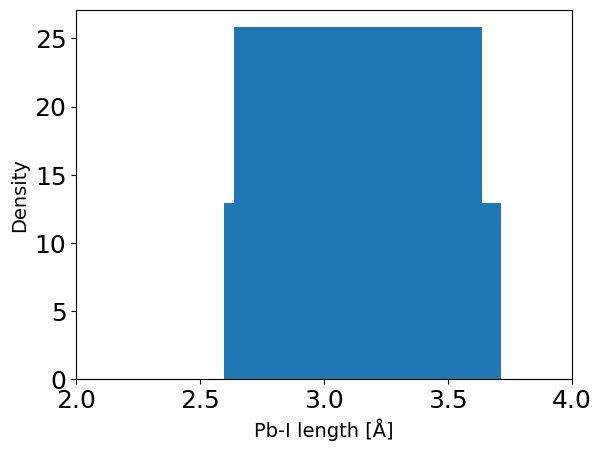

In [20]:
hist, bin_edges = np.histogram(distances, density=True)
plt.bar(bin_edges[:-1], hist, width=1)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlim(2, 4)
plt.xlabel('Pb-I length [Å]', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

## Build functions

In [21]:
# Input: a frame
# Output: a graph, degree, lengths, angles

def structure_analysis(atoms):
    # Get the indices of all Pb, I atoms
    Pb_indices = np.where([element == 'Pb' for element in atoms.get_chemical_symbols()])[0]
    I_indices = np.where([element == 'I' for element in atoms.get_chemical_symbols()])[0]
    
    # All the indices of Is connect to Pbs
    Pb_connections = np.array([[7,  0,  4,  8,  6,  9], [10, 1,  5, 11, 9, 12],
                                                  [14, 2, 8, 15, 13, 16], [17, 3, 11, 18, 16, 19],
                                                  [23, 7, 20, 24, 22, 25], [26, 10, 21, 27, 25, 28], 
                                                  [30, 14, 24, 31, 29, 32], [33, 17, 27, 34, 32, 35]])
    
    # Create an empty graph object
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(Pb_indices)
    G.add_nodes_from(I_indices)
    
    # Color of nodes
    color_map = {i: mainColors['Pb'] for i in Pb_indices}
    color_map.update({i: mainColors['I'] for i in I_indices})
    nx.set_node_attributes(G, color_map, 'color')

    # All the angles: for each Pb, there are 12 angles
    angles = []
    # All the distances: for each Pb, there are 6 Pb-I bond lengths
    distances = []
    
    # PbI_len =  3.4
    for i, Pb_index in enumerate(Pb_indices):
        
        # Distance calculation
        # Pb at the center
        for c in Pb_connections[i]:
            dist = atoms.get_distance(Pb_index, c)
            # Add edges to the graph
            if dist < 3.4:
                G.add_edge(Pb_index, c, distance='{:.1f}'.format(dist))
            distances.append(dist)

        # Angle calculation
        # Directions: U, D, L, R, F, B 
        # Indices:     0, 1, 2, 3, 4, 5
        directions = {direction: index for direction, index in zip(['U', 'D', 'L', 'R', 'F', 'B'], [0, 1, 2, 3, 4, 5])}
        
        # All the 12 angles 
        # (D, c, L), (D, c, R),  (D, c, F), (D, c, B) 
        # (U, c, L), (U, c, R),  (R, c, F), (R, c, B) 
        # (L, c, B), (B, c, R), (R, c, F), (F, c, L)
        ACBs = [(Pb_connections[i][directions[a]], Pb_index, Pb_connections[i][directions[b]]) for (a, b) in [('D', 'L'), ('D', 'R'), ('D', 'F'), ('D', 'B'),\
                                                                                                           ('U', 'L'), ('U', 'R'), ('R', 'F'), ('R', 'B'), \
                                                                                                           ('L', 'B'), ('B', 'R'), ('R', 'F'), ('F', 'L')]]
        
        for acb in ACBs:
            angle = atoms.get_angle(acb[0], acb[1], acb[2])
            angles.append(angle)
    
    return G, distances, angles

In [22]:
def calDegree(G, filename='DegDist.png'):
    # 计算度分布
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    # 可视化度分布
    plt.figure(figsize=(3,3))
    plt.tick_params(direction="in")
    plt.tick_params(axis='x', labelsize=19)
    plt.tick_params(axis='y', labelsize=19)
    x_ticks = np.linspace(0, 7, 8)  # Specify the tick positions
    x_tick_labels = ['$%.0f$' % val for val in x_ticks]  # Specify the tick labels
    plt.xticks(x_ticks, x_tick_labels)
    y_ticks = np.linspace(0, 30, 4)  # Specify the tick positions
    y_tick_labels = ['$%.0f$' % val for val in y_ticks]  # Specify the tick labels
    plt.yticks(y_ticks, y_tick_labels)
    plt.xlim(-0.9,6.9)
    plt.ylim(0, 35)
    # plt.grid()
    plt.bar(*np.unique(degree_sequence, return_counts=True), color='grey')
    
    plt.xlabel('Degree', fontsize=26)
    plt.ylabel('Count', fontsize=26)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    
    return degree_count
    

In [23]:
def calDistdistro(distances, filename='DisDist.png'):
    plt.figure(figsize=(3,3))
    plt.tick_params(direction="in")
    plt.tick_params(axis='x', labelsize=19)
    plt.tick_params(axis='y', labelsize=19)
    # plt.grid()
    plt.hist(distances, bins=100,  range=(2, 3.5), density=False, color='grey')
    plt.bar(bin_edges[:-1], hist, width=1)
    plt.xlim(2, 4)
    plt.xlabel('Pb-I length [Å]', fontsize=26)
    plt.ylabel('Density', fontsize=26)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    return bin_edges[:-1], hist

In [24]:
def calAngledistro(angles,  filename='AngDist.png'):
    plt.figure(figsize=(3,3))
    plt.tick_params(direction="in")
    plt.tick_params(axis='x', labelsize=19)
    plt.tick_params(axis='y', labelsize=19)
    plt.rcParams['text.usetex'] = True
    # plt.grid()
#     plt.bar(bin_edges[:-1], hist, width=1, color=colors['N'])
    plt.hist(angles, bins=20,  range=(0, 180), density=False, color='grey')
    x_ticks = np.linspace(0, 180, 5)  # Specify the tick positions
    x_tick_labels = ['$%.0f^\circ$' % val for val in x_ticks]  # Specify the tick labels
    plt.xticks(x_ticks, x_tick_labels)
    y_ticks = np.linspace(0, 40, 5)  # Specify the tick positions
    y_tick_labels = ['$%.0f$' % val for val in y_ticks]  # Specify the tick labels
    plt.yticks(y_ticks, y_tick_labels)
    plt.xlim(-9, 189)
    plt.ylim(0, 47)
    plt.xlabel('Angle I-Pb-I', fontsize=26)
    plt.ylabel('Count', fontsize=26)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    return bin_edges[:-1], hist

In [40]:
def viewGraph(G, filename='graph.png'):
    plt.figure(figsize=(3,3))
    pos = graphviz_layout(G, prog="neato")
    nx.draw(G, pos, node_color=color_map.values(), node_size=120)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

In [36]:
G, distances, angles = structure_analysis(start_structure)

/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/4135923579.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="neato")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/4135923579.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


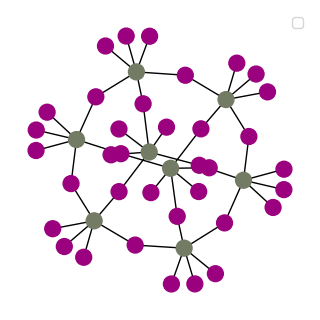

In [37]:
viewGraph(G)
# calDegree(G)
# calDistdistro(distances)
# calAngledistro(angles)

## Dynamics analysis

In [28]:
def hex2rgb(color, fraction=True):
    r = int(color[1:3], 16)
    g = int(color[3:5], 16)
    b = int(color[5:], 16)
    return (r/255., g/255., b/255.) if fraction else (r, g, b) 

for e in ['Pb', 'I', 'C', 'N', 'O']:
    color = hex2rgb(mainColors[e])
    e_an = atomic_numbers[e]
    colors.jmol_colors[e_an] = color
    colors.cpk_colors[e_an] = color

In [29]:
def renderStructure(aseAtoms, outFile='output.pov'):

    # View used to start ag, and find desired viewing angle using view(atoms)
    rot = '0x,0y,0z'  # found using ag: 'view -> rotate'

    generic_projection_settings = {
        'rotation': rot,  # text string with rotation (default='' )
        'radii': .85,  # float, or a list with one float per atom
        'colors': None,  # List: one (r, g, b) tuple per atom
        'show_unit_cell': 2,   # 0, 1, or 2 to not show, show, and show all of cell
    }

    # Extra kwargs only available for povray (All units in angstrom)
    povray_settings = {
        'display': False,  # Display while rendering
        'pause': True,  # Pause when done rendering (only if display)
        'transparent': True,  # Transparent background
        'canvas_width': 2500,  # Width of canvas in pixels
        'canvas_height': None,  # Height of canvas in pixels
        'camera_dist': 50.,  # Distance from camera to front atom
        'image_plane': None,  # Distance from front atom to image plane
        #'camera_type': 'perspective',  # perspective, ultra_wide_angle
        'point_lights': [],             # [[loc1, color1], [loc2, color2],...]
        'area_light': [(2., 3., 40.),  # location
                       'White',       # color
                       .7, .7, 3, 3],  # width, height, Nlamps_x, Nlamps_y
        'background': 'White',        # color
        'textures': None,  # Length of atoms list of texture names
        'celllinewidth': 0.00000001,  # Radius of the cylinders representing the cell
    }


    povray_settings['textures'] = ['intermediate' for a in aseAtoms]
    renderer = write('{}'.format(outFile),\
               aseAtoms, **generic_projection_settings, povray_settings=povray_settings)
    renderer.render()
    print('Rendered.')

In [30]:
# Load trajectory
traj_cluster = read('{}/nvt-pos-1-222.xyz'.format('cluster'), index='::1')

In [31]:
box = np.array([31.7900009155, 31.0900001526, 30.3899993896])

mv: rename frame_* to cluster/dgraph/frame_*: No such file or directory
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="neato")
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


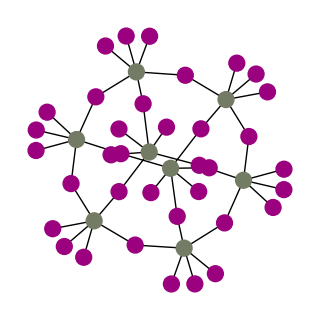

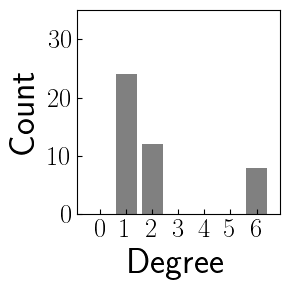

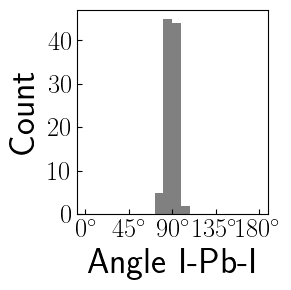

mv: rename frame_* to cluster/dgraph/frame_*: No such file or directory
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="neato")
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


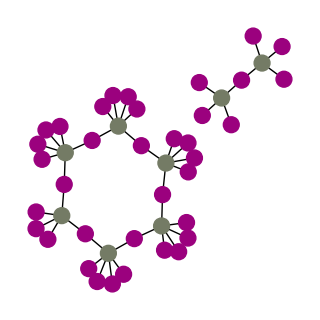

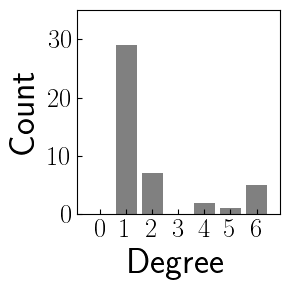

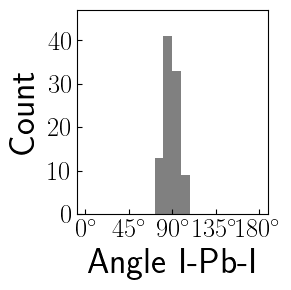

mv: rename frame_* to cluster/dgraph/frame_*: No such file or directory
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="neato")
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


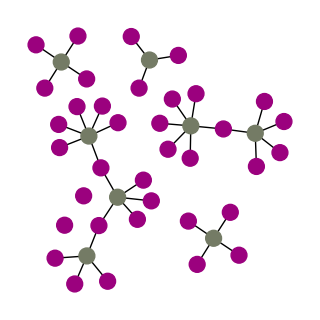

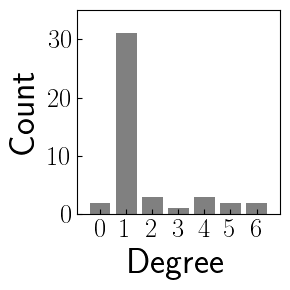

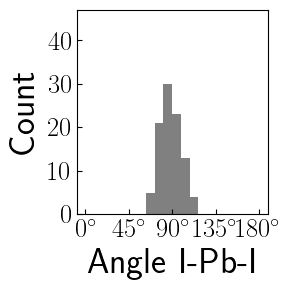

mv: /var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="neato")
rename frame_* to cluster/dgraph/frame_*: No such file or directory
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


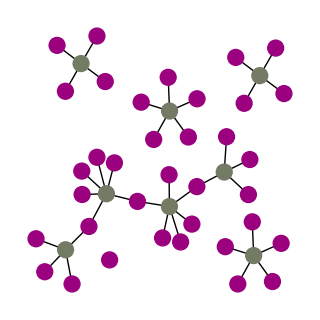

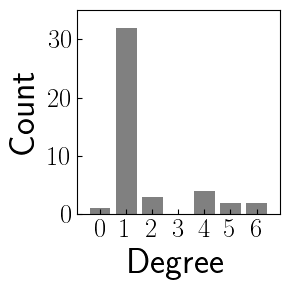

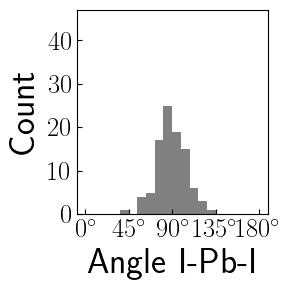

mv: rename frame_* to cluster/dgraph/frame_*: No such file or directory
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="neato")
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


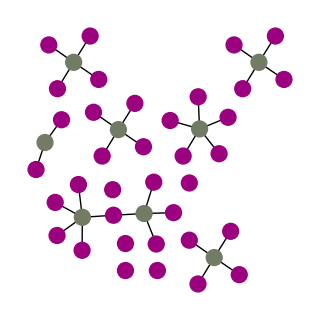

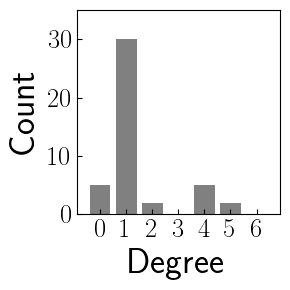

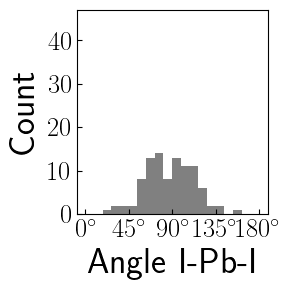

mv: rename frame_* to cluster/dgraph/frame_*: No such file or directory
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="neato")
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


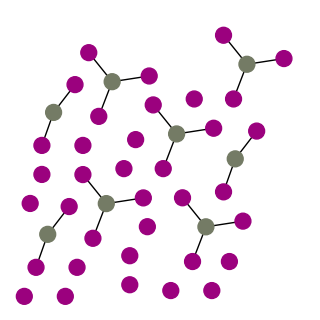

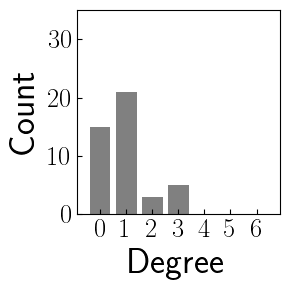

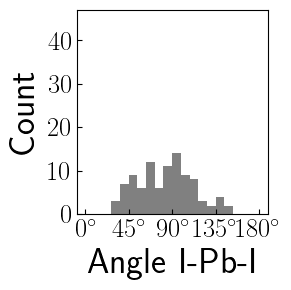

mv: rename frame_* to cluster/dgraph/frame_*/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="neato")
: No such file or directory
/var/folders/vv/nz845l391yg8jtlw9vtc1qq80000gn/T/ipykernel_61174/528350448.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


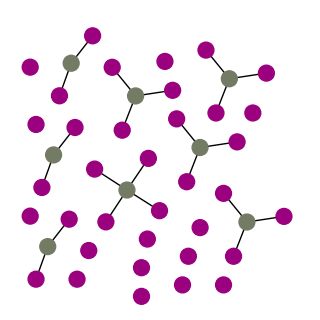

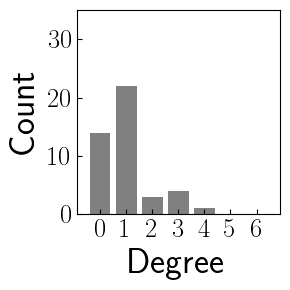

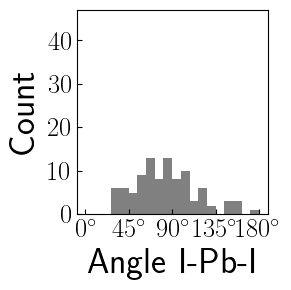

In [39]:
import os
for i in [2**k for k in range(6,13,1)]:
    G, distances, angles = structure_analysis(traj_cluster[i])
    traj_cluster[i].set_cell(Cell(np.eye(3)*box))
    write('cluster/dgraph/R_{}.png'.format(i), traj_cluster[i][0:100])
    #renderStructure(traj_cluster[i][0:100], outFile='frame_{}.pov'.format(i))
    os.system('mv frame_* cluster/dgraph/')
    viewGraph(G, filename='cluster/dgraph/G_{}.png'.format(i))
    calDegree(G, filename='cluster/dgraph/Dg_{}.png'.format(i))
    #calDistdistro(distances, 'cluster/dgraph/Dis_{}.png'.format(i))
    calAngledistro(angles, 'cluster/dgraph/Ang_{}.png'.format(i))